In [22]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dense, BatchNormalization, Flatten
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
#LOAD DATASET (data is already cleaned from notebook.ipynb)
song_df = pd.read_csv("processed_song_data.csv")

song_df.head()

,Track Name,Artist Name(s),Album Name,Album Artist Name(s),Explicit,age,artist_name,dating,family/gospel,genre,...,feelings,light/visual_perceptions,like/girls,movement/places,music,obscene,sadness,shake_the_audience,mood_%,mood
0,Justified & Ancient - Stand by the Jams,The KLF,Songs Collection,The KLF,False,1.0,mukesh,0.000598,0.048857,pop,...,0.117175,0.000598,0.000598,0.000598,0.039288,0.000598,0.380299,0.000598,0.426354,Neutral
1,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,Pitbull,False,1.0,'frankie laine',0.035537,0.027007,pop,...,0.001284,0.212681,0.001284,0.001284,0.118034,0.001284,0.001284,0.001284,0.770510,High Emotion
2,From the Bottom of My Broken Heart,Britney Spears,...Baby One More Time (Digital Deluxe Version),Britney Spears,False,1.0,'johnnie ray',0.002770,0.002770,pop,...,0.225422,0.002770,0.002770,0.002770,0.323794,0.002770,0.002770,0.002770,0.683601,High Emotion
3,Apeman - 2014 Remastered Version,The Kinks,"Lola vs. Powerman and the Moneygoround, Pt. On...",The Kinks,False,1.0,'prez prado',0.048249,0.001548,pop,...,0.001548,0.001548,0.081132,0.129250,0.001548,0.001548,0.225889,0.021500,0.604193,High Emotion
4,You Can't Always Get What You Want,The Rolling Stones,Let It Bleed,The Rolling Stones,False,1.0,'giorgos papadopoulos',0.001350,0.001350,pop,...,0.001350,0.001350,0.001350,0.001350,0.001350,0.001350,0.068800,0.001350,0.523334,Neutral


In [3]:
# Step 4: Feature Extraction
# split data into features and labels.
song_X = song_df.drop(columns=[
    # these are y variables
    'mood', 'mood_%',
    # these are too specific and may lead to overfitting
    'Track Name', 'Artist Name(s)', 'Album Name', 'Album Artist Name(s)', 'artist_name', 'track_name',
    # these are directly used to calculate mood, so to prevent data leakage we will drop them
    "Energy", "Valence", "sadness"
])

song_y = song_df['mood']

In [4]:
# encode labels

# Select categorical columns
categorical_columns = ["genre", "topic"]
categorical_features = song_X[categorical_columns]

# OneHotEncode categorical features
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')
onehot_encoded_features = onehot_encoder.fit_transform(categorical_features)
one_hot_encoded_df = pd.DataFrame(onehot_encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Scale numerical features with Robust Scaler to prevent outliers
# Select numerical columns
numerical_columns = song_X.drop(columns=categorical_columns)

# scale features
robust_scaler = RobustScaler()
scaled_numerical_song_X = robust_scaler.fit_transform(numerical_columns)
song_df_scaled = pd.DataFrame(scaled_numerical_song_X, columns=numerical_columns.columns)


In [5]:
processed_song_X = pd.concat([song_df_scaled, one_hot_encoded_df], axis=1)

In [6]:
# get all value counts
song_y.value_counts()

mood
High Emotion    14660
Neutral         11344
Low Emotion      1862
Name: count, dtype: int64

In [7]:
# encode labels for neural network
categories = [['High Emotion', 'Neutral', 'Low Emotion']]
ohe = OneHotEncoder(sparse_output=False, categories=categories, handle_unknown='error')
new_song_y = ohe.fit_transform(song_y.to_numpy().reshape(-1, 1))

In [8]:
new_song_y.shape

(27866, 3)

In [9]:
#train val test split

# Split the dataset into training (60%), validation (20%), and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(processed_song_X, new_song_y, test_size=0.2, random_state=42, stratify=new_song_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [10]:
# print the shape of the training, validation, and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16719, 40)
y_train shape: (16719, 3)
X_val shape: (5573, 40)
y_val shape: (5573, 3)
X_test shape: (5574, 40)
y_test shape: (5574, 3)


In [11]:
# HANDLE IMBALANCED DATA WITH SMOTE OVERSAMPLING BEFORE TRAINING

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Building Neural Network

In [12]:
# Define the neural network
model = Sequential([
      Flatten(input_shape=(X_train.shape[1:])),
      Dense(128, input_shape=(X_train.shape[1:]),activation='relu'),
      BatchNormalization(),
      Dense(64, activation='relu'),
      BatchNormalization(),
      Dense(32, activation='relu'),
      BatchNormalization(),
      Dense(16, activation='relu'),
      BatchNormalization(),
      Dense(8, activation='relu'),
      BatchNormalization(),
      Dense(3,activation='softmax') # 3 classes for mood (high, neutral, low)
  ])

# Compile the model
model.compile(optimizer= 'adam',
                loss= 'categorical_crossentropy', metrics=['accuracy'])

# show summary
model.summary()

c:\Users\amari\anaconda3\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\amari\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,267 (67.45 KB)

 Trainable params: 16,771 (65.51 KB)

 Non-trainable params: 496 (1.94 KB)

In [14]:
# Training the Model
history = model.fit(X_train, y_train, epochs=50, verbose=1, validation_data=(X_val, y_val))


Epoch 1/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5647 - loss: 0.9345 - val_accuracy: 0.6908 - val_loss: 0.6980
Epoch 2/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7463 - loss: 0.5754 - val_accuracy: 0.7310 - val_loss: 0.5755
Epoch 3/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7670 - loss: 0.5288 - val_accuracy: 0.7328 - val_loss: 0.5698
Epoch 4/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7798 - loss: 0.5002 - val_accuracy: 0.7280 - val_loss: 0.5787
Epoch 5/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7886 - loss: 0.4827 - val_accuracy: 0.7547 - val_loss: 0.5225
Epoch 6/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7938 - loss: 0.4689 - val_accuracy: 0.7658 - val_loss: 0.5031
Epoch 7/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7942 - loss: 0.4715 - val_accuracy: 0.7387 - val_loss: 0.5539
Epoch 8/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8059 - loss: 0.4467 - val_accuracy: 0.

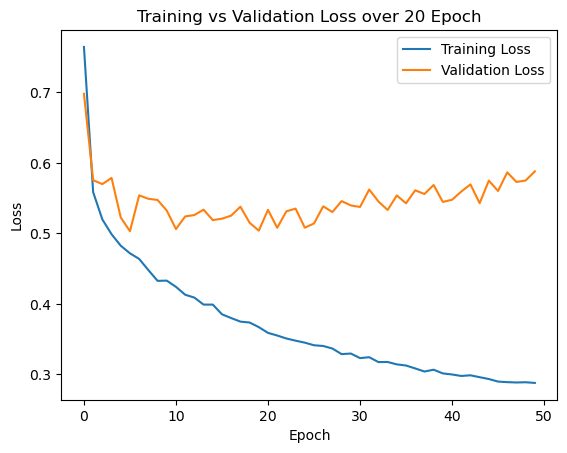

In [15]:
# Plot the training and validation loss over epochs

hist = pd.DataFrame(history.history)

train_loss = hist['loss']
val_loss = hist['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss over 20 Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

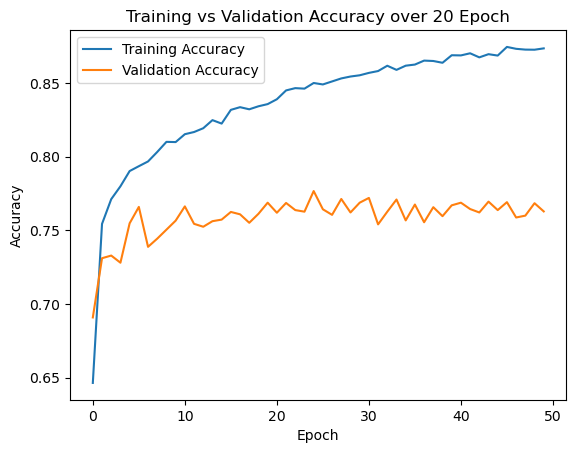

In [16]:
# Plot the training and validation accuracy over epochs

hist = pd.DataFrame(history.history)

train_acc = hist['accuracy']
val_acc = hist['val_accuracy']

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy over 20 Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy} \n")


# predict on test set

y_pred = model.predict(X_test, verbose=0)

# report the classification report

print("Classification Report: \n",classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

Test Loss: 0.5816027522087097, Test Accuracy: 0.7603157758712769 

Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      2932
           1       0.70      0.74      0.72      2269
           2       0.55      0.63      0.59       373

    accuracy                           0.76      5574
   macro avg       0.70      0.72      0.71      5574
weighted avg       0.77      0.76      0.76      5574



In [39]:
#get predicted and ground truth values labels for each class
LABELS = ["High Emotion", "Neutral", "Low Emotion"]

predicted_labels = [LABELS[label] for label in y_pred.argmax(axis=1)]

ground_truth_labels = [LABELS[label] for label in y_test.argmax(axis=1)]

# visualize predicted and ground truth values for each class
results = pd.DataFrame({"predicted": predicted_labels, "ground truth": ground_truth_labels})

print(results.to_string())

         predicted  ground truth
0     High Emotion  High Emotion
1     High Emotion  High Emotion
2     High Emotion  High Emotion
3     High Emotion  High Emotion
4          Neutral       Neutral
5      Low Emotion       Neutral
6     High Emotion  High Emotion
7          Neutral  High Emotion
8          Neutral       Neutral
9          Neutral   Low Emotion
10         Neutral       Neutral
11         Neutral  High Emotion
12    High Emotion  High Emotion
13    High Emotion  High Emotion
14    High Emotion  High Emotion
15         Neutral       Neutral
16     Low Emotion   Low Emotion
17         Neutral       Neutral
18    High Emotion       Neutral
19         Neutral       Neutral
20         Neutral       Neutral
21         Neutral  High Emotion
22         Neutral       Neutral
23    High Emotion  High Emotion
24         Neutral       Neutral
25    High Emotion       Neutral
26    High Emotion  High Emotion
27    High Emotion       Neutral
28    High Emotion  High Emotion
29    High

<Figure size 1000x1000 with 0 Axes>

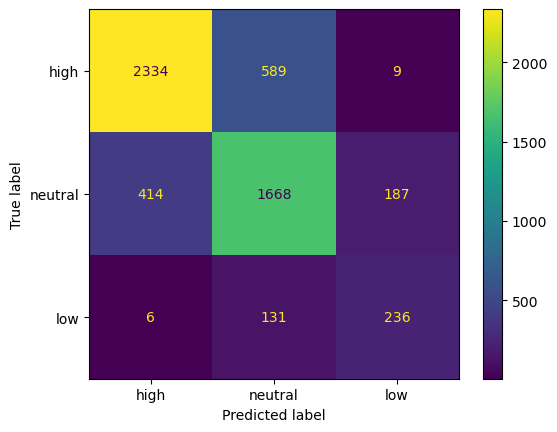

In [28]:
# generate confusion matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# plot confusion matrix

plt.figure(figsize=(10, 10))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["high", "neutral", "low"])
disp.plot()
plt.show()